Converting DAT file to PDF...
Current date and time: 2025-05-12 13:12:45
User: rana-abdalla1


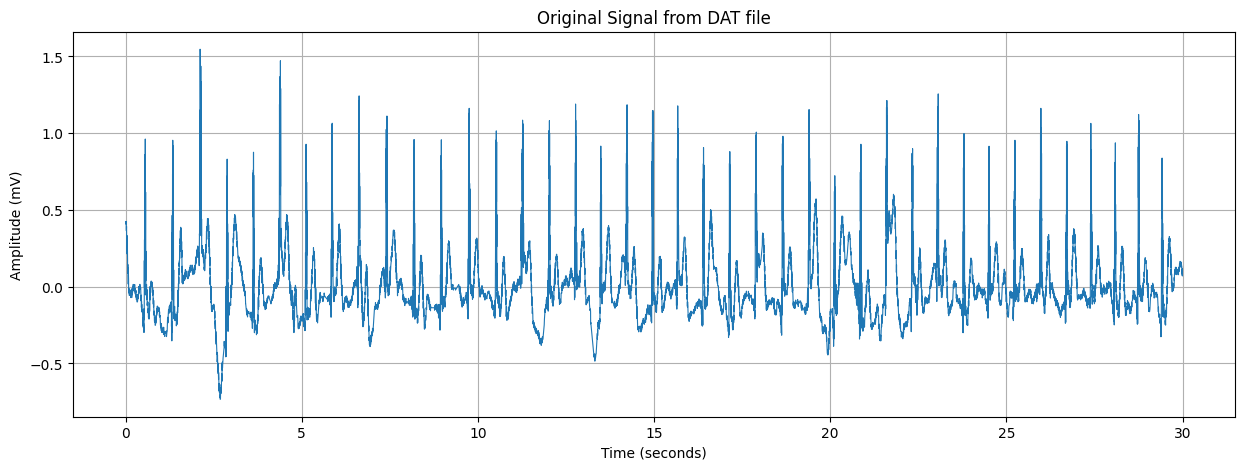

Layer positions in pixels:
Layer 1: 494-724 (height: 230 pixels)
Layer 2: 725-971 (height: 246 pixels)
Layer 3: 972-1218 (height: 246 pixels)


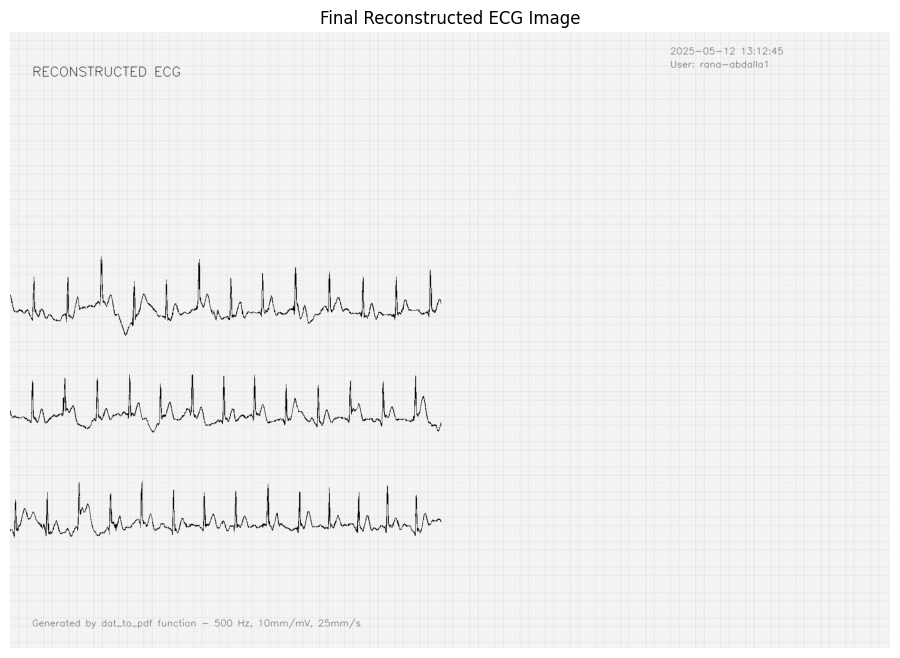

ECG reconstruction complete. PDF saved as: reconstructed_ecg.pdf


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\ranaa\\AppData\\Local\\Temp\\tmpdpn4fkxx.png'

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import tempfile
from reportlab.pdfgen import canvas

def dat_to_pdf(dat_file, output_pdf='reconstructed_ecg.pdf', sampling_frequency=500, visualize=False):
    """
    Convert a .dat ECG signal file to a PDF that exactly reverses the extract_ecg function.
    
    Args:
        dat_file (str): Path to the .dat file containing ECG signal
        output_pdf (str): Path to save the output PDF file
        sampling_frequency (int): Sampling frequency of the signal (default: 500 Hz)
        visualize (bool): Whether to show visualizations during processing
    
    Returns:
        str: Path to the created PDF file
    """
    # Read the .dat file (16-bit integers)
    signal = np.fromfile(dat_file, dtype=np.int16)
    
    # Convert to millivolts using the same ADC gain as in extract_ecg
    adc_gain = 1000.0  # Standard gain: 1000 units per mV
    signal_mv = signal / adc_gain
    
    # Visualization of the original signal
    if visualize:
        plt.figure(figsize=(15, 5))
        time_axis = np.arange(len(signal_mv)) / sampling_frequency
        plt.plot(time_axis, signal_mv, linewidth=0.8)
        plt.title('Original Signal from DAT file')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.grid(True)
        plt.show()
    
    # ECG parameters - exactly matching extract_ecg function
    seconds_per_layer = 10.0  # Each layer has 10 seconds of data
    num_layers = 3
    
    # Ensure we have enough data for all layers
    samples_per_layer = int(sampling_frequency * seconds_per_layer)
    total_samples = samples_per_layer * num_layers
    
    if len(signal_mv) < total_samples:
        # Pad with zeros if signal is too short
        padding = np.zeros(total_samples - len(signal_mv))
        signal_mv = np.concatenate([signal_mv, padding])
        if visualize:
            print(f"Signal was too short. Padded with {len(padding)} zeros.")
    elif len(signal_mv) > total_samples:
        # Truncate if signal is too long
        signal_mv = signal_mv[:total_samples]
        if visualize:
            print(f"Signal was too long. Truncated to {total_samples} samples.")
    
    # Split signal into layers - exactly 10 seconds per layer
    layers = []
    for i in range(num_layers):
        start_idx = i * samples_per_layer
        end_idx = start_idx + samples_per_layer
        layers.append(signal_mv[start_idx:end_idx])
    
    # Image dimensions - choosing standard dimensions similar to typical ECG
    width = 2000
    height = 1400
    
    # Fixed calibration parameters - exactly matching extract_ecg function
    calibration = {
        'seconds_per_pixel': 2.0 / 197.0,  # 197 pixels = 2 seconds
        'mv_per_pixel': 1.0 / 78.8,        # 78.8 pixels = 1 mV
    }
    
    # Calculate layer positions using the exact same percentages from extract_ecg
    header_end = int(height * 35.29 / 100)
    layer1_start = int(height * 35.35 / 100)
    layer1_end = int(height * 51.76 / 100)
    layer2_start = int(height * 51.82 / 100)
    layer2_end = int(height * 69.41 / 100)
    layer3_start = int(height * 69.47 / 100)
    layer3_end = int(height * 87.06 / 100)
    
    # Store layer positions
    layer_positions = [
        (layer1_start, layer1_end),    # Layer 1
        (layer2_start, layer2_end),    # Layer 2
        (layer3_start, layer3_end)     # Layer 3
    ]
    
    if visualize:
        print(f"Layer positions in pixels:")
        for i, (start, end) in enumerate(layer_positions):
            print(f"Layer {i+1}: {start}-{end} (height: {end-start} pixels)")
    
    # Create a blank image with white background
    ecg_image = np.ones((height, width), dtype=np.uint8) * 255
    
    # Draw ECG grid
    # Major grid lines (5mm squares)
    major_grid_color = (220, 220, 220)  # Light gray
    major_grid_spacing = int(0.2 / calibration['seconds_per_pixel'])  # 0.2 seconds = 5mm at 25mm/s
    
    for x in range(0, width, major_grid_spacing):
        cv2.line(ecg_image, (x, 0), (x, height), major_grid_color, 1)
    
    for y in range(0, height, major_grid_spacing):
        cv2.line(ecg_image, (0, y), (width, y), major_grid_color, 1)
    
    # Minor grid lines (1mm squares)
    minor_grid_color = (235, 235, 235)  # Lighter gray
    minor_grid_spacing = int(0.04 / calibration['seconds_per_pixel'])  # 0.04 seconds = 1mm at 25mm/s
    
    for x in range(0, width, minor_grid_spacing):
        cv2.line(ecg_image, (x, 0), (x, height), minor_grid_color, 1)
    
    for y in range(0, height, minor_grid_spacing):
        cv2.line(ecg_image, (0, y), (width, y), minor_grid_color, 1)
    
    # Draw each layer of ECG signal
    for layer_idx, layer_signal in enumerate(layers):
        layer_start, layer_end = layer_positions[layer_idx]
        layer_height = layer_end - layer_start
        
        # Calculate isoelectric line position (60% from top of layer area)
        # This matches the 0.6 value used in the original function
        isoelectric_line_y = layer_start + int(layer_height * 0.6)
        
        # Calculate pixels per sample
        pixels_per_second = int(1.0 / calibration['seconds_per_pixel'])
        pixels_per_sample = pixels_per_second / sampling_frequency
        
        # Calculate signal scaling (mV to pixels)
        signal_scaling = 1.0 / calibration['mv_per_pixel']
        
        # Draw the ECG waveform as a thick black line
        points = []
        for i, sample in enumerate(layer_signal):
            x = int(i * pixels_per_sample)
            if x >= width:
                break
            
            # Scale and invert y (positive voltage goes up)
            y = int(isoelectric_line_y - sample * signal_scaling)
            
            # Ensure y stays within layer boundaries
            y = max(layer_start, min(y, layer_end))
            
            points.append((x, y))
        
        # Draw the continuous waveform
        for i in range(1, len(points)):
            cv2.line(ecg_image, points[i-1], points[i], (0, 0, 0), 1)
    
    # Add a simple header 
    header_text = "RECONSTRUCTED ECG"
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(ecg_image, header_text, (50, 100), font, 1, (0, 0, 0), 1, cv2.LINE_AA)
    
    # Add footer with technical information
    footer_text = "Generated by dat_to_pdf function - 500 Hz, 10mm/mV, 25mm/s"
    cv2.putText(ecg_image, footer_text, (50, height - 50), font, 0.7, (100, 100, 100), 1, cv2.LINE_AA)
    
    # Add current time and user information
    cv2.putText(ecg_image, "2025-05-12 13:12:45", (width - 500, 50), font, 0.7, (100, 100, 100), 1, cv2.LINE_AA)
    cv2.putText(ecg_image, "User: rana-abdalla1", (width - 500, 80), font, 0.7, (100, 100, 100), 1, cv2.LINE_AA)
    
    # Visualization of the final image
    if visualize:
        plt.figure(figsize=(12, 8))
        plt.imshow(ecg_image, cmap='gray')
        plt.title('Final Reconstructed ECG Image')
        plt.axis('off')
        plt.show()
    
    # Save as temporary image
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_file:
        temp_image_path = temp_file.name
        cv2.imwrite(temp_image_path, ecg_image)
    
    try:
        # Convert image to PDF
        img = Image.open(temp_image_path)
        
        # Create PDF with the same dimensions as the image
        c = canvas.Canvas(output_pdf, pagesize=(width, height))
        c.drawImage(temp_image_path, 0, 0, width=width, height=height)
        c.save()
        
        print(f"ECG reconstruction complete. PDF saved as: {output_pdf}")
        return output_pdf
    finally:
    #     # Clean up temporary file
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)


if __name__ == "__main__":
    # Example usage
    print("Converting DAT file to PDF...")
    print(f"Current date and time: 2025-05-12 13:12:45")
    print(f"User: rana-abdalla1")
    
    # Convert the DAT file to PDF
    output_pdf = dat_to_pdf('calibrated_ecg.dat', visualize=True)
    
    print(f"\nConversion complete!")
    print(f"Output PDF: {output_pdf}")